# Imports

In [2]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import cv2

sns.set()
%matplotlib inline

# Abstract

For this notebook I selected a dataset that contains handwritten letters and numbers to be my classification dataset. The data contains both lowercase and upercase letters. I choose this dataset because I have not worked with images before to train a model and wanted to have that experience. I plan to use support vector machines to determine what handwritten letter or number the image is. The reason I will not choose to use Multi-Layer Perceptron (Neural Networks) is because from my experience neural networks are very data hungry and I believe this is not enough images to make the dataframe to justify a Multi-Layer Perceptron (Neural Networks) model. For my regression dataset I have choosen to predit the price of used cars based on the features that the car has. The reason I choose this dataset is because people sell their used cars everyday and I want to know what has the biggest affect on the price based on a cars feature. For this dataset I would be using a linear regression model to predit the price of a used car. 

# Section 1: Prepping the Regression datasets

I will be cleaning the data that my model will use. Some of the columns my model will use is Location, Year, Kilometers_Driven, Fuel_Type, Owner_Type, Engine, Transmission, Seats and a new modify price column.

In [3]:
# loading in the data from the csv file
df_cars = pd.read_csv('data/Regression/train-data.csv')
df_cars.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [5]:
# selecting the columns that will be used for the model
selected_features = ['Location', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type',
                    'Engine', 'Power', 'Seats', 'Price']
df_cars =df_cars[selected_features]
df_cars.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price
0,Mumbai,2010,72000,CNG,Manual,First,998 CC,58.16 bhp,5.0,1.75
1,Pune,2015,41000,Diesel,Manual,First,1582 CC,126.2 bhp,5.0,12.50
2,Chennai,2011,46000,Petrol,Manual,First,1199 CC,88.7 bhp,5.0,4.50
3,Chennai,2012,87000,Diesel,Manual,First,1248 CC,88.76 bhp,7.0,6.00
4,Coimbatore,2013,40670,Diesel,Automatic,Second,1968 CC,140.8 bhp,5.0,17.74


In [7]:
# checking nulls and droping null
print(df_cars.isnull().sum())
df_cars.dropna(inplace=True)
df_cars.isnull().sum()

Location              0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Engine               36
Power                36
Seats                42
Price                 0
dtype: int64


Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Engine               0
Power                0
Seats                0
Price                0
dtype: int64

In [9]:
# modifying the price to make it into USD
def convert_price_usd(price):
    # at the current time when assignment took place
    # 1 INR = 0.013
    return (price * 100000) * 0.013

df_cars['USD_Price'] = df_cars['Price'].apply(convert_price_usd)
df_cars.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price,USD_Price
0,Mumbai,2010,72000,CNG,Manual,First,998 CC,58.16 bhp,5.0,1.75,2275.0
1,Pune,2015,41000,Diesel,Manual,First,1582 CC,126.2 bhp,5.0,12.50,16250.0
2,Chennai,2011,46000,Petrol,Manual,First,1199 CC,88.7 bhp,5.0,4.50,5850.0
3,Chennai,2012,87000,Diesel,Manual,First,1248 CC,88.76 bhp,7.0,6.00,7800.0
4,Coimbatore,2013,40670,Diesel,Automatic,Second,1968 CC,140.8 bhp,5.0,17.74,23062.0


In [10]:
# Creating dummy variables for the categorical columns 
df_cars = pd.get_dummies(df_cars, columns=['Fuel_Type', 'Owner_Type', 'Transmission', 'Location'])
df_cars.head()

,Year,Kilometers_Driven,Engine,Power,Seats,Price,USD_Price,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Electric,...,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune
0,2010,72000,998 CC,58.16 bhp,5.0,1.75,2275.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2015,41000,1582 CC,126.2 bhp,5.0,12.50,16250.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,2011,46000,1199 CC,88.7 bhp,5.0,4.50,5850.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2012,87000,1248 CC,88.76 bhp,7.0,6.00,7800.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,2013,40670,1968 CC,140.8 bhp,5.0,17.74,23062.0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [11]:
# removing the CC from the Engine column so that only int would appear
def remove_cc(value):
    arr = value.split(' ')
    return int(arr[0])

df_cars['Engine'] = df_cars['Engine'].apply(remove_cc)
df_cars.head()

,Year,Kilometers_Driven,Engine,Power,Seats,Price,USD_Price,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Electric,...,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune
0,2010,72000,998,58.16 bhp,5.0,1.75,2275.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2015,41000,1582,126.2 bhp,5.0,12.50,16250.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,2011,46000,1199,88.7 bhp,5.0,4.50,5850.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2012,87000,1248,88.76 bhp,7.0,6.00,7800.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,2013,40670,1968,140.8 bhp,5.0,17.74,23062.0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [12]:
# removing the bhp from the Power column
def remove_bph(value):
    arr = value.split(' ')
    if arr[0] == 'null':
        return None
    
    return float(arr[0])

df_cars['Power'] = df_cars['Power'].apply(remove_bph)
df_cars.head()

,Year,Kilometers_Driven,Engine,Power,Seats,Price,USD_Price,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Electric,...,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune
0,2010,72000,998,58.16,5.0,1.75,2275.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2015,41000,1582,126.20,5.0,12.50,16250.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,2011,46000,1199,88.70,5.0,4.50,5850.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2012,87000,1248,88.76,7.0,6.00,7800.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,2013,40670,1968,140.80,5.0,17.74,23062.0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [13]:
#checking for nulls if functions created any nulls and droping if any
print(df_cars.isnull().sum())
df_cars.dropna(inplace=True)
df_cars.isnull().sum()

Year                           0
Kilometers_Driven              0
Engine                         0
Power                        103
Seats                          0
Price                          0
USD_Price                      0
Fuel_Type_CNG                  0
Fuel_Type_Diesel               0
Fuel_Type_Electric             0
Fuel_Type_LPG                  0
Fuel_Type_Petrol               0
Owner_Type_First               0
Owner_Type_Fourth & Above      0
Owner_Type_Second              0
Owner_Type_Third               0
Transmission_Automatic         0
Transmission_Manual            0
Location_Ahmedabad             0
Location_Bangalore             0
Location_Chennai               0
Location_Coimbatore            0
Location_Delhi                 0
Location_Hyderabad             0
Location_Jaipur                0
Location_Kochi                 0
Location_Kolkata               0
Location_Mumbai                0
Location_Pune                  0
dtype: int64


Year                         0
Kilometers_Driven            0
Engine                       0
Power                        0
Seats                        0
Price                        0
USD_Price                    0
Fuel_Type_CNG                0
Fuel_Type_Diesel             0
Fuel_Type_Electric           0
Fuel_Type_LPG                0
Fuel_Type_Petrol             0
Owner_Type_First             0
Owner_Type_Fourth & Above    0
Owner_Type_Second            0
Owner_Type_Third             0
Transmission_Automatic       0
Transmission_Manual          0
Location_Ahmedabad           0
Location_Bangalore           0
Location_Chennai             0
Location_Coimbatore          0
Location_Delhi               0
Location_Hyderabad           0
Location_Jaipur              0
Location_Kochi               0
Location_Kolkata             0
Location_Mumbai              0
Location_Pune                0
dtype: int64

# Section 2: Linear Regression


In [14]:
# getting X and Y for our model to take in and predict
selected_features = ['Year', 'Kilometers_Driven', 'Fuel_Type_CNG', 'Fuel_Type_Diesel', 'Fuel_Type_LPG',
                     'Fuel_Type_Petrol', 'Transmission_Automatic', 'Transmission_Manual', 'Owner_Type_First',
                     'Owner_Type_Fourth & Above', 'Owner_Type_Second', 'Owner_Type_Third', 'Seats', 'Engine', 'Power']
X = df_cars[selected_features]
y = df_cars['USD_Price']

In [15]:
# spliting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [16]:
# creating the model and fitting the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [27]:
# getting model predictions
y_pred = model.predict(X_test)

# evalutation
scores = cross_val_score(model, X_test, y_test, cv=3)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.69 accuracy with a standard deviation of 0.01


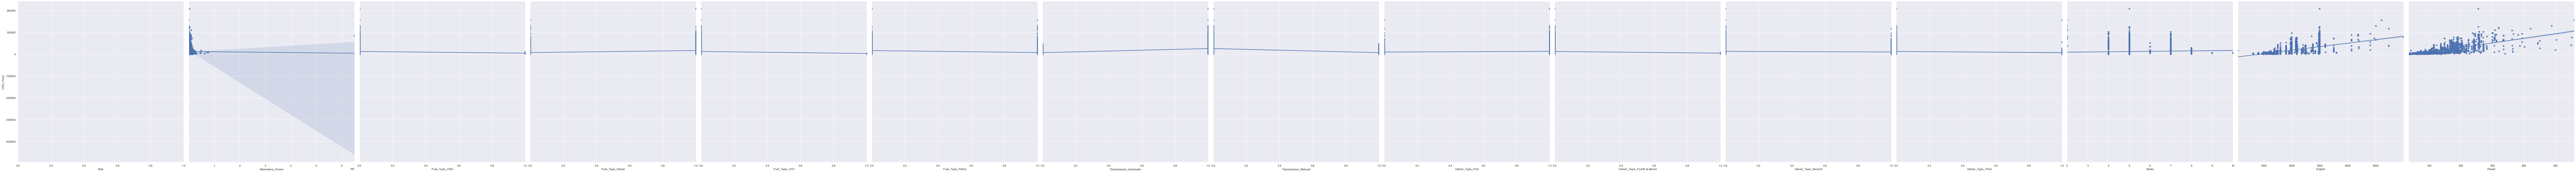

In [37]:
# graph
sns.pairplot(df_cars, x_vars=selected_features, y_vars=["USD_Price"],
             height=10, kind="reg");

# Section 3: Prepping the classification dataset

In [28]:
# load in the csv file for the classifcation with the labels
IMAGES_PATH = 'data/Classification/Img'

df_letters = pd.read_csv('data/Classification/english.csv')
df_letters.head()

,image,label
0,Img/img001-001.png,0
1,Img/img001-002.png,0
2,Img/img001-003.png,0
3,Img/img001-004.png,0
4,Img/img001-005.png,0


In [29]:
# checking for nulls 
df_letters.isnull().sum()

image    0
label    0
dtype: int64

In [30]:
# function to get label from dataframe letters
def get_label(img):
    cond = df_letters['image'] == 'Img/'+img
    return list(df_letters[cond].label)[0]

In [31]:
# reading the images from the Img folder and using cv2 to get the pixels 
# and then flatten the image to feed into the machine learning model
images_labels = []
images = []

for img in os.listdir(IMAGES_PATH):
    label = get_label(img)
    image = cv2.imread(os.path.join(IMAGES_PATH, img), 0)
    image = cv2.resize(image, (45, 45))
    image = image.flatten()
    
    images_labels.append(label)
    images.append(image)

# Section 4: Classification with a Neural Network (or classifier of choice)

In [32]:
# spliting the data
X_train, X_test, y_train, y_test = train_test_split(images, images_labels, test_size=0.25)

In [33]:
# making the model and training it
model = svm.SVC()
model.fit(X_train, y_train)

SVC()

In [35]:
# getting model predictions
y_pred = model.predict(X_test)

# evalutation
accuracy = model.score(X_test, y_test)
print("%0.2f accuracy" % accuracy)

0.41 accuracy


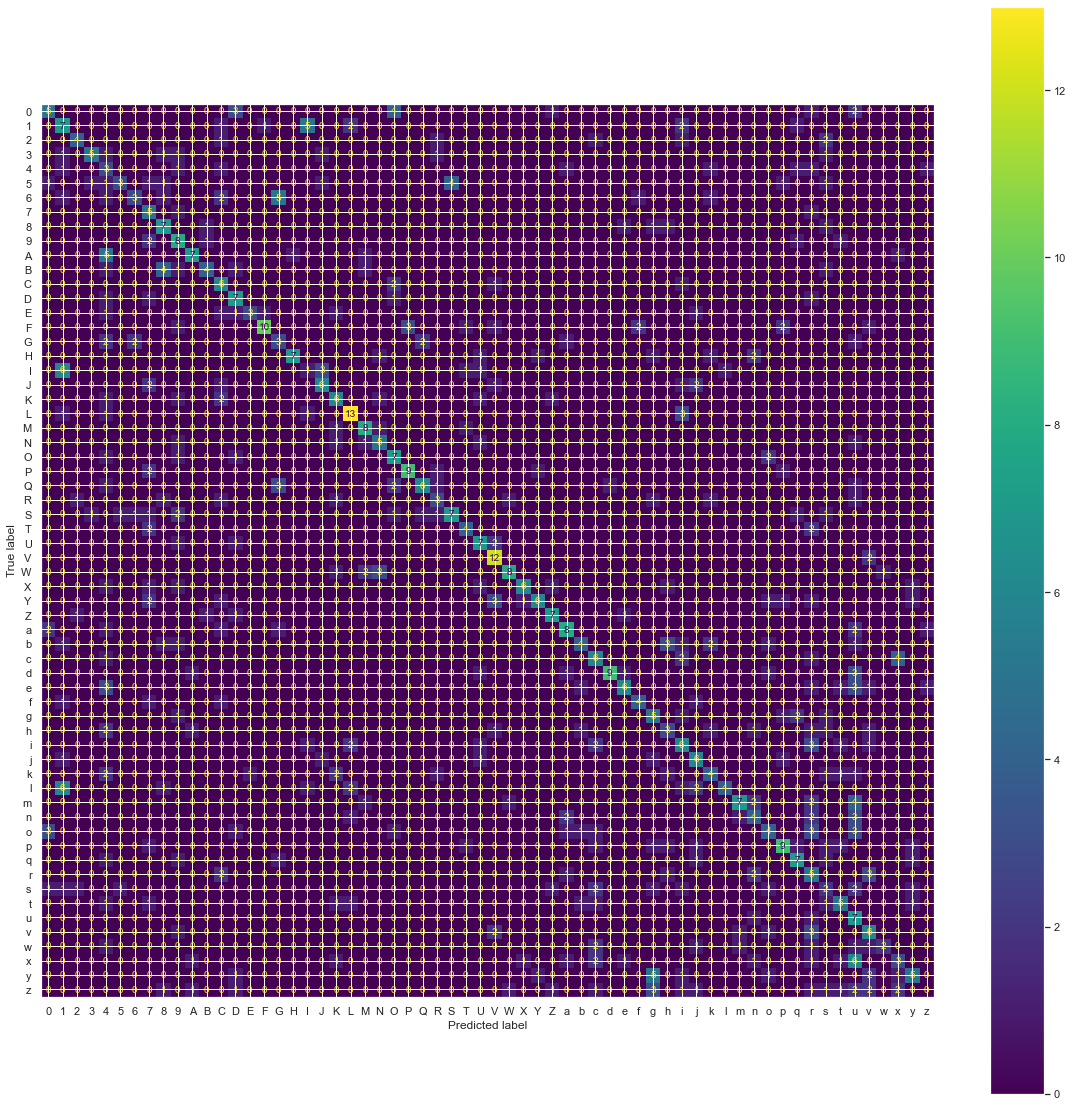

In [39]:
# graph
fig, ax = plt.subplots(figsize=(20,20))
metrics.plot_confusion_matrix(estimator=model, 
                              X=X_test, 
                              y_true=y_test, 
                              ax=ax)

# Conclusions


For the classification model it was able to classify L and V the best while it struggled with the rest of the handwritten characters. This could be due to the small amount of images that was in the dataset, to further improve this classification model I would look for another dataset that includes more handwritten images. Also, maybe just have either lowercase or upercase letters instead of having both would give me a better result for the model. If I had a lot more images I could of used a different model such as a neural network. For the classifcation I had to extract to pixels of each image and put a label to them in a dataframe I did this by using cv2 to extract the pixels of the image and then I flatten the image. 

For the regression model I was trying to predict the price of a used car using a linear regression model. In order to do this I had to create 'dummy' variables for some of the columns and remove the characters in some of the other columns the reason for this is because linear regression model only accepts numbers. This dataset was a real mess to use linear regression model on I had to do a lot of data cleaning to get this to work and only was able to achieve a 69% accuracy score. I believe if the column milage had one type either kmpl or km/kg it would of obtain a higher score. To improve this I would need to convert kmpl to km/kg or vice versa to obtain a higher score on the testing data.